In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.primitives import Estimator
from ffsim import qiskit as fqs
 
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from ffsim.qiskit.jordan_wigner import jordan_wigner

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from functools import partial
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
import pandas as pd
import matplotlib.pyplot as plt


/home/david/.venvs/tikzplot/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#QiskitRuntimeService.save_account(token='8SD5nQy9GnzvNMC67WFuRDcvh6ibXEjzNQETQf4b1yIC',overwrite=True)

In [3]:
from typing import Sequence
 
import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph
 
IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}
 
 
def create_linear_chains(num_orbitals: int) -> PyGraph:
    """In zig-zag layout, there are two linear chains (with connecting qubits between
    the chains). This function creates those two linear chains: a rustworkx PyGraph
    with two disconnected linear chains. Each chain contains `num_orbitals` number
    of nodes, that is, in the final graph there are `2 * num_orbitals` number of nodes.
 
    Args:
        num_orbitals (int): Number orbitals or nodes in each linear chain. They are
            also known as alpha-alpha interaction qubits.
 
    Returns:
        A rustworkx.PyGraph with two disconnected linear chains each with `num_orbitals`
            number of nodes.
    """
    G = rustworkx.PyGraph()
 
    for n in range(num_orbitals):
        G.add_node(n)
 
    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)
 
    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)
 
    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)
 
    return G
 
 
def create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """This function creates the complete zigzag graph that 'can be mapped' to an IBM QPU with
    heavy-hex connectivity (the zigzag must be an isomorphic sub-graph to the QPU/backend
    coupling graph for it to be mapped).
    The zigzag pattern includes both linear chains (alpha-alpha interactions) and connecting
    qubits between the linear chains (alpha-beta interactions).
 
    Args:
        num_orbitals (int): Number of orbitals, that is, number of nodes in each alpha-alpha linear chain.
        backend_coupling_graph (PyGraph): The coupling graph of the backend on which the LUCJ ansatz
            will be mapped and run. This function takes the coupling graph as a undirected
            `rustworkx.PyGraph` where there is only one 'undirected' edge between two nodes,
            that is, qubits. Usually, the coupling graph of a IBM backend is directed (for example, Eagle devices
            such as ibm_brisbane) or may have two edges between two nodes (for example, Heron `ibm_torino`).
            A user needs to be make such graphs undirected and/or remove duplicate edges to make them
            compatible with this function.
 
    Returns:
        G_new (PyGraph): The graph with IBM backend compliant zigzag pattern.
        num_alpha_beta_qubits (int): Number of connecting qubits between the linear chains
            in the zigzag pattern. While we want as many connecting (alpha-beta) qubits between
            the linear (alpha-alpha) chains, we cannot accommodate all due to qubit and connectivity
            constraints of backends. This is the maximum number of connecting qubits the zigzag pattern
            can have while being backend compliant (that is, isomorphic to backend coupling graph).
    """
    isomorphic = False
    G = create_linear_chains(num_orbitals=num_orbitals)
 
    num_iters = num_orbitals
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + num_orbitals, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(
            backend_coupling_graph, G_new
        )
        num_iters -= 1
 
    return G_new, num_alpha_beta_qubits
 
 
def lightweight_layout_error_scoring(
    backend: BackendV2,
    virtual_edges: Sequence[Sequence[int]],
    physical_layouts: Sequence[int],
    two_q_gate_name: str,
) -> list[list[list[int], float]]:
    """Lightweight and heuristic function to score isomorphic layouts. There can be many zigzag patterns,
    each with different set of physical qubits, that can be mapped to a backend. Some of them may
    include less noise qubits and couplings than others. This function computes a simple error score
    for each such layout. It sums up 2Q gate error for all couplings in the zigzag pattern (layout) and
    measurement of errors of physical qubits in the layout to compute the error score.
 
    Note:
        This lightweight scoring can be refined using concepts such as mapomatic.
 
    Args:
        backend (BackendV2): A backend.
        virtual_edges (Sequence[Sequence[int]]): Edges in the device compliant zigzag pattern where
            nodes are numbered from 0 to (2 * num_orbitals + num_alpha_beta_qubits).
        physical_layouts (Sequence[int]): All physical layouts of the zigzag pattern that are isomorphic
            to each other and to the larger backend coupling map.
        two_q_gate_name (str): The name of the two-qubit gate of the backend. The name is used for fetching
            two-qubit gate error from backend properties.
 
    Returns:
        scores (list): A list of lists where each sublist contains two items. First item is the layout, and
            second item is a float representing error score of the layout. The layouts in the `scores` are
            sorted in the ascending order of error score.
    """
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])
 
    return sorted(scores, key=lambda x: x[1])
 
 
def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()
 
    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass
 
    return backend_coupling_graph
 
 
def get_zigzag_physical_layout(
    num_orbitals: int, backend: BackendV2, score_layouts: bool = True
) -> tuple[list[int], int]:
    """The main function that generates the zigzag pattern with physical qubits that can be used
    as an `intial_layout` in a preset passmanager/transpiler.
 
    Args:
        num_orbitals (int): Number of orbitals.
        backend (BackendV2): A backend.
        score_layouts (bool): Optional. If `True`, it uses the `lightweight_layout_error_scoring`
            function to score the isomorphic layouts and returns the layout with less erroneous qubits.
            If `False`, returns the first isomorphic subgraph.
 
    Returns:
        A tuple of device compliant layout (list[int]) with zigzag pattern and an int representing
            number of alpha-beta-interactions.
    """
    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)
 
    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )
 
    isomorphic_mappings = rustworkx.vf2_mapping(
        backend_coupling_graph, G, subgraph=True
    )
    isomorphic_mappings = list(isomorphic_mappings)
 
    edges = list(G.edge_list())
 
    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)
 
    two_q_gate_name = IBM_TWO_Q_GATES.intersection(
        backend.configuration().basis_gates
    ).pop()
 
    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )
 
        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits
 
    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

# Classical chemistry

- Build nitrogen molecule, set basis set and bond length
- Obtain molecular and one and two electron integrals (hcore, eri) which define the fermionic electronic Hamiltonian
- Uuse t1 and t2 amplitudes from ccsd ansatz to initialize lucj

In [4]:
from pyscf.tools import fcidump

open_shell = False
spin_sq = 0
 
R = 2.1

mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (R, 0, 0)]],
    basis="sto-6g",
    symmetry="Dooh",
)
 
# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)
 
exact_energy = -109.27710729903457

converged SCF energy = -107.86599840826


In [5]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -108.6449813088028  E_corr = -0.7789829005424329


# **Initialize LUCJ and map to qubits via JW**

In [6]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]
 
# define lucj operator, initialize with t1, t2 amplitudes from ccsd
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
    regularization=0.1
)

# construct quantum circuit for lucj ansatz
nelec = (num_elec_a, num_elec_b)
qubits = QuantumRegister(2 * num_orbitals, name="q") # 2*N qubits for 2*N spin-orbitals
circuit_ucj = QuantumCircuit(qubits) 
circuit_ucj.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit_ucj.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit_ucj.measure_all()

In [9]:
circuit_ucj.num_qubits

16

In [10]:
service = QiskitRuntimeService()
backend = service.backend("ibm_fez")
print(f"Using backend {backend.name}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-29 18:08:04,290: Default instance not set. Searching all available instances.


Using backend ibm_fez


# **Set the Heavy-hex "zig-zag" layout**

In [11]:
initial_layout, _ = get_zigzag_physical_layout(num_orbitals, backend=backend)
 
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit_ucj)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/ pre-init passes): OrderedDict({'sx': 746, 'rz': 712, 'cz': 214, 'measure': 16, 'x': 4, 'barrier': 1})


# **Submit sampler job on IBM-Q**
We collect bitstring samples for ground state energy esimation.

In [10]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

# Job results

In [22]:
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/d0452a76f5f0435a94da777e07d63524:02dde04a-2cef-4099-97bb-ee03dd1b86e5::'
)
job = service.job('d4a6svvnmdfs73acju8g')
primitive_result = job.result()
pub_result = primitive_result[0]

In [23]:
pub_result = primitive_result[0]

# Option A: counts dict
counts = pub_result.data.meas.get_counts()  # {'1010...': 7, ...}
with open("counts.txt", "w") as f:
    for b, c in counts.items():
        f.write(f"{b} {int(c)}\n")

We estimate the ground state energy of the Hamiltonian using `diagonalize_fermionic_hamiltonian` function from qiskit. This performs self-consistent configuration recovery to approximate CI coefficients.

We send the bitstring samples into a CI subspace and diagonalize them with SQD in this subspace, subject to constraints (symmetric spin, spin singlets)

In [34]:
from functools import partial
 
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)
 
# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5
 
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200
 
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)
 
# List to capture intermediate results
result_history = []
 
 
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )
 
 
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -108.43861293947117
		Subspace dimension: 16900
	Subsample 1
		Energy: -108.43861293947117
		Subspace dimension: 16900
	Subsample 2
		Energy: -108.43861293947117
		Subspace dimension: 16900
Iteration 2
	Subsample 0
		Energy: -108.67018410440468
		Subspace dimension: 281961
	Subsample 1
		Energy: -108.56212003791069
		Subspace dimension: 263169
	Subsample 2
		Energy: -108.62130358503134
		Subspace dimension: 260100
Iteration 3
	Subsample 0
		Energy: -108.72387371850812
		Subspace dimension: 442225
	Subsample 1
		Energy: -108.75393321727861
		Subspace dimension: 421201
	Subsample 2
		Energy: -108.72510279827274
		Subspace dimension: 409600
Iteration 4
	Subsample 0
		Energy: -108.7913960139095
		Subspace dimension: 665856
	Subsample 1
		Energy: -108.80683767668248
		Subspace dimension: 659344
	Subsample 2
		Energy: -108.78039412661558
		Subspace dimension: 648025
Iteration 5
	Subsample 0
		Energy: -108.82499123176113
		Subspace dimension: 872356
	Subsamp

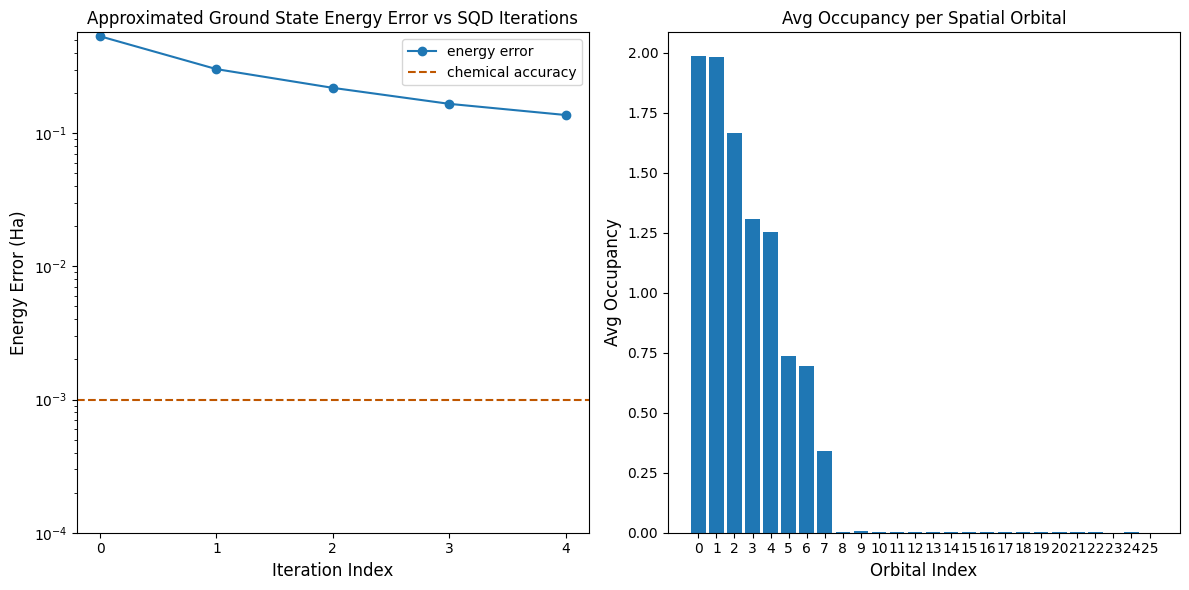

In [35]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
 
# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001
 
# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))
 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
plt.tight_layout()
plt.show()